# Computation on Arrays: Broadcasting

We saw in the previous section how NumPy's universal functions can be used to *vectorize* operations and thereby remove slow Python loops.
Another means of vectorizing operations is to use NumPy's *broadcasting* functionality.
Broadcasting is simply a set of rules for applying binary ufuncs (e.g., addition, subtraction, multiplication, etc.) on arrays of different sizes.

## Introducing Broadcasting

Recall that for arrays of the same size, binary operations are performed on an element-by-element basis:

In [218]:
import numpy as np

In [219]:
a = np.array([0, 1, 2])
b = np.array([5, 5, 5])
a + b

array([5, 6, 7])

Broadcasting allows these types of binary operations to be performed on arrays of different sizes–for example, we can just as easily add a scalar (think of it as a zero-dimensional array) to an array:

In [220]:
a + 5

array([5, 6, 7])

We can think of this as an operation that stretches or duplicates the value ``5`` into the array ``[5, 5, 5]``, and adds the results.
The advantage of NumPy's broadcasting is that this duplication of values does not actually take place, but it is a useful mental model as we think about broadcasting.

We can similarly extend this to arrays of higher dimension. Observe the result when we add a one-dimensional array to a two-dimensional array:

In [221]:
M = np.ones((3, 3))
M

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [222]:
M + a

array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]])

Here the one-dimensional array ``a`` is stretched, or broadcast across the second dimension in order to match the shape of ``M``.

While these examples are relatively easy to understand, more complicated cases can involve broadcasting of both arrays. Consider the following example:

In [223]:
a = np.arange(3)
b = np.arange(3)[:, np.newaxis]

print(a)
print(b)

[0 1 2]
[[0]
 [1]
 [2]]


In [224]:
a + b

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

Just as before we stretched or broadcasted one value to match the shape of the other, here we've stretched *both* ``a`` and ``b`` to match a common shape, and the result is a two-dimensional array!
The geometry of these examples is visualized in the following figure (Code to produce this plot can be found in the [appendix](06.00-Figure-Code.ipynb#Broadcasting), and is adapted from source published in the [astroML](http://astroml.org) documentation. Used by permission).

### Centering an array

In the previous section, we saw that ufuncs allow a NumPy user to remove the need to explicitly write slow Python loops. Broadcasting extends this ability.
One commonly seen example is when centering an array of data.
Imagine you have an array of 10 observations, each of which consists of 3 values.
Using the standard convention (see [Data Representation in Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb#Data-Representation-in-Scikit-Learn)), we'll store this in a $10 \times 3$ array:

In [225]:
X = np.random.random((10, 3))

We can compute the mean of each feature using the ``mean`` aggregate across the first dimension:

In [226]:
Xmean = X.mean(0)
Xmean

array([0.4834947 , 0.44527771, 0.58151035])

And now we can center the ``X`` array by subtracting the mean (this is a broadcasting operation):

In [227]:
X_centered = X - Xmean

To double-check that we've done this correctly, we can check that the centered array has near zero mean:

In [228]:
X_centered.mean(0)

array([-1.11022302e-17, -8.88178420e-17, -7.77156117e-17])

To within machine precision, the mean is now zero.

# Comparisons, Masks, and Boolean Logic

This section covers the use of Boolean masks to examine and manipulate values within NumPy arrays.
Masking comes up when you want to extract, modify, count, or otherwise manipulate values in an array based on some criterion: for example, you might wish to count all values greater than a certain value, or perhaps remove all outliers that are above some threshold.
In NumPy, Boolean masking is often the most efficient way to accomplish these types of tasks.

## Example: Counting Rainy Days

Imagine you have a series of data that represents the amount of precipitation each day for a year in a given city.
For example, here we'll load the daily rainfall statistics for the city of Seattle in 2014, using Pandas (which is covered in more detail in [Chapter 3](03.00-Introduction-to-Pandas.ipynb)):

In [229]:
import numpy as np
import pandas as pd

# use pandas to extract rainfall inches as a NumPy array
rainfall = pd.read_csv('data/Seattle2014.csv')['PRCP'].values
inches = rainfall / 254.0  # 1/10mm -> inches
inches.shape

(365,)

The array contains 365 values, giving daily rainfall in inches from January 1 to December 31, 2014.

As a first quick visualization, let's look at the histogram of rainy days, which was generated using Matplotlib (we will explore this tool more fully in [Chapter 4](04.00-Introduction-To-Matplotlib.ipynb)):

In [230]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # set plot styles

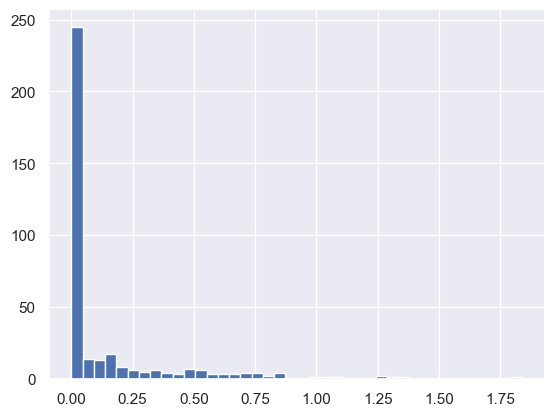

In [231]:
plt.hist(inches, 40);

This histogram gives us a general idea of what the data looks like: despite its reputation, the vast majority of days in Seattle saw near zero measured rainfall in 2014.
But this doesn't do a good job of conveying some information we'd like to see: for example, how many rainy days were there in the year? What is the average precipitation on those rainy days? How many days were there with more than half an inch of rain?

## Comparison Operators as ufuncs

In [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) we introduced ufuncs, and focused in particular on arithmetic operators. We saw that using ``+``, ``-``, ``*``, ``/``, and others on arrays leads to element-wise operations.
NumPy also implements comparison operators such as ``<`` (less than) and ``>`` (greater than) as element-wise ufuncs.
The result of these comparison operators is always an array with a Boolean data type.
All six of the standard comparison operations are available:

In [232]:
x = np.array([1, 2, 3, 4, 5])

In [233]:
x < 3  # less than

array([ True,  True, False, False, False])

In [234]:
x > 3  # greater than

array([False, False, False,  True,  True])

In [235]:
rng = np.random.RandomState(0)
x = rng.randint(10, size=(3, 4))
x

array([[5, 0, 3, 3],
       [7, 9, 3, 5],
       [2, 4, 7, 6]], dtype=int32)

In [236]:
x < 6

array([[ True,  True,  True,  True],
       [False, False,  True,  True],
       [ True,  True, False, False]])

In each case, the result is a Boolean array, and NumPy provides a number of straightforward patterns for working with these Boolean results.

## Working with Boolean Arrays

Given a Boolean array, there are a host of useful operations you can do.
We'll work with ``x``, the two-dimensional array we created earlier.

In [237]:
print(x)

[[5 0 3 3]
 [7 9 3 5]
 [2 4 7 6]]


### Counting entries

To count the number of ``True`` entries in a Boolean array, ``np.count_nonzero`` is useful:

In [238]:
# how many values less than 6?
np.count_nonzero(x < 6)

8

We see that there are eight array entries that are less than 6.
Another way to get at this information is to use ``np.sum``; in this case, ``False`` is interpreted as ``0``, and ``True`` is interpreted as ``1``:

In [239]:
np.sum(x < 6)

np.int64(8)

The benefit of ``sum()`` is that like with other NumPy aggregation functions, this summation can be done along rows or columns as well:

In [240]:
# how many values less than 6 in each row?
np.sum(x < 6, axis=1)

array([4, 2, 2])

This counts the number of values less than 6 in each row of the matrix.

If we're interested in quickly checking whether any or all the values are true, we can use (you guessed it) ``np.any`` or ``np.all``:

In [241]:
# are there any values greater than 8?
np.any(x > 8)

np.True_

In [242]:
# are there any values less than zero?
np.any(x < 0)

np.False_

In [243]:
# are all values less than 10?
np.all(x < 10)

np.True_

In [244]:
# are all values equal to 6?
np.all(x == 6)

np.False_

``np.all`` and ``np.any`` can be used along particular axes as well. For example:

In [245]:
# are all values in each row less than 8?
np.all(x < 8, axis=1)

array([ True, False,  True])

Here all the elements in the first and third rows are less than 8, while this is not the case for the second row.

Finally, a quick warning: as mentioned in [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb), Python has built-in ``sum()``, ``any()``, and ``all()`` functions. These have a different syntax than the NumPy versions, and in particular will fail or produce unintended results when used on multidimensional arrays. Be sure that you are using ``np.sum()``, ``np.any()``, and ``np.all()`` for these examples!

## Boolean Arrays as Masks

In the preceding section we looked at aggregates computed directly on Boolean arrays.
A more powerful pattern is to use Boolean arrays as masks, to select particular subsets of the data themselves.
Returning to our ``x`` array from before, suppose we want an array of all values in the array that are less than, say, 5:

In [246]:
x

array([[5, 0, 3, 3],
       [7, 9, 3, 5],
       [2, 4, 7, 6]], dtype=int32)

We can obtain a Boolean array for this condition easily, as we've already seen:

In [247]:
x < 5

array([[False,  True,  True,  True],
       [False, False,  True, False],
       [ True,  True, False, False]])

Now to *select* these values from the array, we can simply index on this Boolean array; this is known as a *masking* operation:

In [248]:
x[x < 5]

array([0, 3, 3, 3, 2, 4], dtype=int32)

What is returned is a one-dimensional array filled with all the values that meet this condition; in other words, all the values in positions at which the mask array is ``True``.

We are then free to operate on these values as we wish.
For example, we can compute some relevant statistics on our Seattle rain data:

In [249]:
# construct a mask of all rainy days
rainy = (inches > 0)

# construct a mask of all summer days (June 21st is the 172nd day)
days = np.arange(365)
summer = (days > 172) & (days < 262)

print("Median precip on rainy days in 2014 (inches):   ",
      np.median(inches[rainy]))
print("Median precip on summer days in 2014 (inches):  ",
      np.median(inches[summer]))
print("Maximum precip on summer days in 2014 (inches): ",
      np.max(inches[summer]))
print("Median precip on non-summer rainy days (inches):",
      np.median(inches[rainy & ~summer]))

Median precip on rainy days in 2014 (inches):    0.19488188976377951
Median precip on summer days in 2014 (inches):   0.0
Maximum precip on summer days in 2014 (inches):  0.8503937007874016
Median precip on non-summer rainy days (inches): 0.20078740157480315


By combining Boolean operations, masking operations, and aggregates, we can very quickly answer these sorts of questions for our dataset.

# Fancy Indexing

In the previous sections, we saw how to access and modify portions of arrays using simple indices (e.g., ``arr[0]``), slices (e.g., ``arr[:5]``), and Boolean masks (e.g., ``arr[arr > 0]``).
In this section, we'll look at another style of array indexing, known as *fancy indexing*.
Fancy indexing is like the simple indexing we've already seen, but we pass arrays of indices in place of single scalars.
This allows us to very quickly access and modify complicated subsets of an array's values.

## Exploring Fancy Indexing

Fancy indexing is conceptually simple: it means passing an array of indices to access multiple array elements at once.
For example, consider the following array:

In [250]:
import numpy as np
rand = np.random.RandomState(42)

x = rand.randint(100, size=10)
print(x)

[51 92 14 71 60 20 82 86 74 74]


Suppose we want to access three different elements. We could do it like this:

In [251]:
[x[3], x[7], x[2]]

[np.int32(71), np.int32(86), np.int32(14)]

Alternatively, we can pass a single list or array of indices to obtain the same result:

In [252]:
ind = [3, 7, 4]
x[ind]

array([71, 86, 60], dtype=int32)

When using fancy indexing, the shape of the result reflects the shape of the *index arrays* rather than the shape of the *array being indexed*:

In [253]:
ind = np.array([[3, 7],
                [4, 5]])
x[ind]

array([[71, 86],
       [60, 20]], dtype=int32)

Fancy indexing also works in multiple dimensions. Consider the following array:

In [254]:
X = np.arange(12).reshape((3, 4))
X

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

Like with standard indexing, the first index refers to the row, and the second to the column:

In [255]:
row = np.array([0, 1, 2])
col = np.array([2, 1, 3])
X[row, col]

array([ 2,  5, 11])

Notice that the first value in the result is ``X[0, 2]``, the second is ``X[1, 1]``, and the third is ``X[2, 3]``.
The pairing of indices in fancy indexing follows all the broadcasting rules that were mentioned in [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb).
So, for example, if we combine a column vector and a row vector within the indices, we get a two-dimensional result:

In [256]:
X[row[:, np.newaxis], col]

array([[ 2,  1,  3],
       [ 6,  5,  7],
       [10,  9, 11]])

Here, each row value is matched with each column vector, exactly as we saw in broadcasting of arithmetic operations.
For example:

In [257]:
row[:, np.newaxis] * col

array([[0, 0, 0],
       [2, 1, 3],
       [4, 2, 6]])

It is always important to remember with fancy indexing that the return value reflects the *broadcasted shape of the indices*, rather than the shape of the array being indexed.

## Combined Indexing

For even more powerful operations, fancy indexing can be combined with the other indexing schemes we've seen:

In [258]:
print(X)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


We can combine fancy and simple indices:

In [259]:
X[2, [2, 0, 1]]

array([10,  8,  9])

We can also combine fancy indexing with slicing:

In [260]:
X[1:, [2, 0, 1]]

array([[ 6,  4,  5],
       [10,  8,  9]])

And we can combine fancy indexing with masking:

## Modifying Values with Fancy Indexing

Just as fancy indexing can be used to access parts of an array, it can also be used to modify parts of an array.
For example, imagine we have an array of indices and we'd like to set the corresponding items in an array to some value:

In [261]:
x = np.arange(10)
i = np.array([2, 1, 8, 4])
x[i] = 99
print(x)

[ 0 99 99  3 99  5  6  7 99  9]


We can use any assignment-type operator for this. For example:

In [262]:
x[i] -= 10
print(x)

[ 0 89 89  3 89  5  6  7 89  9]


Notice, though, that repeated indices with these operations can cause some potentially unexpected results. Consider the following:

In [263]:
x = np.zeros(10)
x[[0, 0]] = [4, 6]
print(x)

[6. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Where did the 4 go? The result of this operation is to first assign ``x[0] = 4``, followed by ``x[0] = 6``.
The result, of course, is that ``x[0]`` contains the value 6.

Fair enough, but consider this operation:

In [264]:
i = [2, 3, 3, 4, 4, 4]
x[i] += 1
x

array([6., 0., 1., 1., 1., 0., 0., 0., 0., 0.])

You might expect that ``x[3]`` would contain the value 2, and ``x[4]`` would contain the value 3, as this is how many times each index is repeated. Why is this not the case?
Conceptually, this is because ``x[i] += 1`` is meant as a shorthand of ``x[i] = x[i] + 1``. ``x[i] + 1`` is evaluated, and then the result is assigned to the indices in x.
With this in mind, it is not the augmentation that happens multiple times, but the assignment, which leads to the rather nonintuitive results.

So what if you want the other behavior where the operation is repeated? For this, you can use the ``at()`` method of ufuncs (available since NumPy 1.8), and do the following:

In [265]:
x = np.zeros(10)
np.add.at(x, i, 1)
print(x)

[0. 0. 1. 2. 3. 0. 0. 0. 0. 0.]


The ``at()`` method does an in-place application of the given operator at the specified indices (here, ``i``) with the specified value (here, 1).
Another method that is similar in spirit is the ``reduceat()`` method of ufuncs, which you can read about in the NumPy documentation.

# Sorting Arrays

Up to this point we have been concerned mainly with tools to access and operate on array data with NumPy.
This section covers algorithms related to sorting values in NumPy arrays.
These algorithms are a favorite topic in introductory computer science courses: if you've ever taken one, you probably have had dreams (or, depending on your temperament, nightmares) about *insertion sorts*, *selection sorts*, *merge sorts*, *quick sorts*, *bubble sorts*, and many, many more.
All are means of accomplishing a similar task: sorting the values in a list or array.

For example, a simple *selection sort* repeatedly finds the minimum value from a list, and makes swaps until the list is sorted. We can code this in just a few lines of Python:

In [293]:
import numpy as np

def selection_sort(x):
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        (x[i], x[swap]) = (x[swap], x[i])
    return x

In [292]:
x = np.array([2, 1, 4, 3, 5])
selection_sort(x)

array([1, 2, 3, 4, 5])

As any first-year computer science major will tell you, the selection sort is useful for its simplicity, but is much too slow to be useful for larger arrays.
For a list of $N$ values, it requires $N$ loops, each of which does on order $\sim N$ comparisons to find the swap value.
In terms of the "big-O" notation often used to characterize these algorithms (see [Big-O Notation](#Aside:-Big-O-Notation)), selection sort averages $\mathcal{O}[N^2]$: if you double the number of items in the list, the execution time will go up by about a factor of four.

Even selection sort, though, is much better than my all-time favorite sorting algorithms, the *bogosort*:

In [291]:
def bogosort(x):
    while np.any(x[:-1] > x[1:]):
        np.random.shuffle(x)
    return x

In [269]:
x = np.array([2, 1, 4, 3, 5])
bogosort(x)

array([1, 2, 3, 4, 5])

This silly sorting method relies on pure chance: it repeatedly applies a random shuffling of the array until the result happens to be sorted.
With an average scaling of $\mathcal{O}[N \times N!]$, (that's *N* times *N* factorial) this should–quite obviously–never be used for any real computation.

Fortunately, Python contains built-in sorting algorithms that are *much* more efficient than either of the simplistic algorithms just shown. We'll start by looking at the Python built-ins, and then take a look at the routines included in NumPy and optimized for NumPy arrays.

## Fast Sorting in NumPy: ``np.sort`` and ``np.argsort``

Although Python has built-in ``sort`` and ``sorted`` functions to work with lists, we won't discuss them here because NumPy's ``np.sort`` function turns out to be much more efficient and useful for our purposes.
By default ``np.sort`` uses an $\mathcal{O}[N\log N]$, *quicksort* algorithm, though *mergesort* and *heapsort* are also available. For most applications, the default quicksort is more than sufficient.

To return a sorted version of the array without modifying the input, you can use ``np.sort``:

In [270]:
x = np.array([2, 1, 4, 3, 5])
np.sort(x)

array([1, 2, 3, 4, 5])

If you prefer to sort the array in-place, you can instead use the ``sort`` method of arrays:

In [271]:
x.sort()
print(x)

[1 2 3 4 5]


A related function is ``argsort``, which instead returns the *indices* of the sorted elements:

In [272]:
x = np.array([2, 1, 4, 3, 5])
i = np.argsort(x)
print(i)

[1 0 3 2 4]


The first element of this result gives the index of the smallest element, the second value gives the index of the second smallest, and so on.
These indices can then be used (via fancy indexing) to construct the sorted array if desired:

In [273]:
x[i]

array([1, 2, 3, 4, 5])

### Sorting along rows or columns

A useful feature of NumPy's sorting algorithms is the ability to sort along specific rows or columns of a multidimensional array using the ``axis`` argument. For example:

In [274]:
rand = np.random.RandomState(42)
X = rand.randint(0, 10, (4, 6))
print(X)

[[6 3 7 4 6 9]
 [2 6 7 4 3 7]
 [7 2 5 4 1 7]
 [5 1 4 0 9 5]]


In [275]:
# sort each column of X
np.sort(X, axis=0)

array([[2, 1, 4, 0, 1, 5],
       [5, 2, 5, 4, 3, 7],
       [6, 3, 7, 4, 6, 7],
       [7, 6, 7, 4, 9, 9]], dtype=int32)

In [276]:
# sort each row of X
np.sort(X, axis=1)

array([[3, 4, 6, 6, 7, 9],
       [2, 3, 4, 6, 7, 7],
       [1, 2, 4, 5, 7, 7],
       [0, 1, 4, 5, 5, 9]], dtype=int32)

Keep in mind that this treats each row or column as an independent array, and any relationships between the row or column values will be lost!

## Partial Sorts: Partitioning

Sometimes we're not interested in sorting the entire array, but simply want to find the *k* smallest values in the array. NumPy provides this in the ``np.partition`` function. ``np.partition`` takes an array and a number *K*; the result is a new array with the smallest *K* values to the left of the partition, and the remaining values to the right, in arbitrary order:

In [277]:
x = np.array([7, 2, 3, 1, 6, 5, 4])
np.partition(x, 3)

array([1, 2, 3, 4, 5, 6, 7])

Note that the first three values in the resulting array are the three smallest in the array, and the remaining array positions contain the remaining values.
Within the two partitions, the elements have arbitrary order.

Similarly to sorting, we can partition along an arbitrary axis of a multidimensional array:

In [278]:
np.partition(X, 2, axis=1)

array([[3, 4, 6, 6, 7, 9],
       [2, 3, 4, 6, 7, 7],
       [1, 2, 4, 5, 7, 7],
       [0, 1, 4, 5, 5, 9]], dtype=int32)

The result is an array where the first two slots in each row contain the smallest values from that row, with the remaining values filling the remaining slots.

Finally, just as there is a ``np.argsort`` that computes indices of the sort, there is a ``np.argpartition`` that computes indices of the partition.
We'll see this in action in the following section.

# Structured Data: NumPy's Structured Arrays

While often our data can be well represented by a homogeneous array of values, sometimes this is not the case. This section demonstrates the use of NumPy's *structured arrays* and *record arrays*, which provide efficient storage for compound, heterogeneous data.  While the patterns shown here are useful for simple operations, scenarios like this often lend themselves to the use of Pandas ``Dataframe``s, which we'll explore in [Chapter 3](03.00-Introduction-to-Pandas.ipynb).

In [279]:
import numpy as np

Imagine that we have several categories of data on a number of people (say, name, age, and weight), and we'd like to store these values for use in a Python program.
It would be possible to store these in three separate arrays:

In [280]:
name = ['Alice', 'Bob', 'Cathy', 'Doug']
age = [25, 45, 37, 19]
weight = [55.0, 85.5, 68.0, 61.5]

But this is a bit clumsy. There's nothing here that tells us that the three arrays are related; it would be more natural if we could use a single structure to store all of this data.
NumPy can handle this through structured arrays, which are arrays with compound data types.

Recall that previously we created a simple array using an expression like this:

In [281]:
x = np.zeros(4, dtype=int)

We can similarly create a structured array using a compound data type specification:

In [282]:
# Use a compound data type for structured arrays
data = np.zeros(4, dtype={'names':('name', 'age', 'weight'),
                          'formats':('U10', 'i4', 'f8')})
print(data.dtype)

[('name', '<U10'), ('age', '<i4'), ('weight', '<f8')]


Here ``'U10'`` translates to "Unicode string of maximum length 10," ``'i4'`` translates to "4-byte (i.e., 32 bit) integer," and ``'f8'`` translates to "8-byte (i.e., 64 bit) float."
We'll discuss other options for these type codes in the following section.

Now that we've created an empty container array, we can fill the array with our lists of values:

In [283]:
data['name'] = name
data['age'] = age
data['weight'] = weight
print(data)

[('Alice', 25, 55. ) ('Bob', 45, 85.5) ('Cathy', 37, 68. )
 ('Doug', 19, 61.5)]


As we had hoped, the data is now arranged together in one convenient block of memory.

The handy thing with structured arrays is that you can now refer to values either by index or by name:

In [284]:
# Get all names
data['name']

array(['Alice', 'Bob', 'Cathy', 'Doug'], dtype='<U10')

In [285]:
# Get first row of data
data[0]

np.void(('Alice', 25, 55.0), dtype=[('name', '<U10'), ('age', '<i4'), ('weight', '<f8')])

In [286]:
# Get the name from the last row
data[-1]['name']

np.str_('Doug')

Using Boolean masking, this even allows you to do some more sophisticated operations such as filtering on age:

In [287]:
# Get names where age is under 30
data[data['age'] < 30]['name']

array(['Alice', 'Doug'], dtype='<U10')

Note that if you'd like to do any operations that are any more complicated than these, you should probably consider the Pandas package, covered in the next chapter.
As we'll see, Pandas provides a ``Dataframe`` object, which is a structure built on NumPy arrays that offers a variety of useful data manipulation functionality similar to what we've shown here, as well as much, much more.

## More Advanced Compound Types

It is possible to define even more advanced compound types.
For example, you can create a type where each element contains an array or matrix of values.
Here, we'll create a data type with a ``mat`` component consisting of a $3\times 3$ floating-point matrix:

In [288]:
tp = np.dtype([('id', 'i8'), ('mat', 'f8', (3, 3))])
X = np.zeros(1, dtype=tp)
print(X[0])
print(X['mat'][0])

(0, [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


Now each element in the ``X`` array consists of an ``id`` and a $3\times 3$ matrix.
Why would you use this rather than a simple multidimensional array, or perhaps a Python dictionary?
The reason is that this NumPy ``dtype`` directly maps onto a C structure definition, so the buffer containing the array content can be accessed directly within an appropriately written C program.
If you find yourself writing a Python interface to a legacy C or Fortran library that manipulates structured data, you'll probably find structured arrays quite useful!